In [273]:
from floorplan import Box, Net, FloorPlan

import cvxpy as cp
from cvxpy import Variable, Constant, Minimize, Problem
import placedb
import pylab
import math

import joblib

from sklearn.manifold import SpectralEmbedding

import scipy.io as io
import scipy.sparse.csgraph as csgraph

import jax
from jax import jit, vmap, random, grad
from jax.experimental import optimizers
from jax import numpy as jnp

from functools import partial
import itertools

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import collections as mc

import datetime
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
from ucsdpcb import PcbDB

In [275]:
!ls _PCBBenchmarks/

bm9  namer.py  README.md


In [276]:
numCores = joblib.cpu_count()

bm = 9 # which benchmark to load
design = "bm{}".format(bm)
pcb_path = "_PCBBenchmarks/bm{}/bm{}.routed.kicad_pcb".format(bm,bm)
db = PcbDB.kicadPcbDataBase(pcb_path)

Build Kicad Pcb database...


In [277]:
name2idx = {}
compw = []
comph = []
compx = []
compy = []
movable = []
initrot = []
initm = []
mirror = []
netss = []
offsets = []
size = []

maxx = 0
maxy = 0
minx = 99999999
miny = 99999999

constraint_threshold = 0 # distance between pairs of components to determine relative position constraints

In [278]:
sumarea = 0
# gather rotation and coordinates of components
for i in range(db.getInstancesCount()):
    inst = db.getInstance(i)
    compid = inst.getComponentId()

    angle = int(inst.getAngle())
    if inst.isLocked():
        movable.append(False)
    else:
        movable.append(True)
    if (angle == 0):
        initrot.append(False)
        initm.append(False)
    elif (angle == 90):
        initrot.append(True)
        initm.append(False)
    elif (angle == 180):
        initrot.append(False)
        initm.append(True)
    elif (angle == 270):
        initrot.append(True)
        initm.append(True)
        
    compx.append(inst.getX() - 0.5 * ((1-int(initrot[-1]))*db.getCompBBoxW(compid) + 
                                      (int(initrot[-1]))*db.getCompBBoxH(compid)))
    compy.append(inst.getY() - 0.5 * ((1-int(initrot[-1]))*db.getCompBBoxH(compid) + 
                                      (int(initrot[-1]))*db.getCompBBoxW(compid)))
    compw.append(db.getCompBBoxW(compid))
    comph.append(db.getCompBBoxH(compid))
    
    if compx[-1] < minx:
        minx = compx[-1]
    if compy[-1] < miny:
        miny = compy[-1]
        
    if True:
        if compx[-1] + comph[-1] > maxx:
            maxx = compx[-1] + comph[-1]
        if compy[-1] + compw[-1] > maxy:
            maxy = compy[-1] + compw[-1]
    else:
        if compx[-1] + compw[-1] > maxx:
            maxx = compx[-1] + compw[-1]
        if compy[-1] + comph[-1] > maxy:
            maxy = compy[-1] + comph[-1]
    
    print(i,inst.getX(), inst.getY(), initrot[-1], db.getCompBBoxW(compid), db.getCompBBoxH(compid), 
          angle, not inst.isLocked())
    sumarea += db.getCompBBoxW(compid)* db.getCompBBoxH(compid)
print("util: {}".format(sumarea/((maxx-minx)*(maxy-miny))))
print('num nodes: {} ({} movable)'.format(len(compx), len([m for m in movable if m])))

0 149.606 100.8634 True 4.04 2.06 270 True
1 151.8666 100.8634 True 4.04 2.06 270 True
2 140.5636 105.2322 True 4.04 2.06 90 True
3 142.7988 100.6856 False 4.04 2.06 180 True
4 145.0594 105.2068 True 6.2 6.2 270 True
5 149.479 108.6104 True 4.2 2.2 270 True
6 151.7396 108.585 True 4.2 2.2 270 True
7 156.083 104.902 True 10.2 3.7 90 False
util: 0.5859955650013281
num nodes: 8 (7 movable)


In [279]:
"""Gather pin offset information """
for i in range(db.getNumNets()):
    net = db.getNet(i)
    pins = net.getPins()
    netss.append([])
    offsets.append([])
    for p in pins:
        instid = p.getInstId()
        netss[-1].append(instid)
        px = db.getPinPositionX(p)
        py = db.getPinPositionY(p)
        inst = db.getInstance(instid)
        ix = inst.getX() 
        iy = inst.getY()
        w = comph[instid]
        h = compw[instid]

        angle = int(inst.getAngle())

        xoff = (1-int(initrot[instid]))*(px-ix)/h + (int(initrot[instid]))*(px-ix)/w
        yoff = (1-int(initrot[instid]))*(py-iy)/w + (int(initrot[instid]))*(py-iy)/h
        assert np.abs(xoff) < 1.0
        assert np.abs(yoff) < 1.0
        if True:
            t = xoff
            xoff = yoff
            yoff = t

        if (angle == 0):##
            offsets[-1].append((xoff,yoff))
        elif (angle == 90):##
            offsets[-1].append((yoff,xoff))
        elif (angle == 180):##
            offsets[-1].append((xoff,yoff))
        elif (angle == 270):##
            offsets[-1].append((yoff,xoff))
        else:
            assert False
            
offsets = [o for o, n in zip(offsets, netss) if len(n)>=2]        
netss = [n for n in netss if len(n)>= 2]
netlens = [len(n) for n in netss]
maxlenidx = np.array(netlens).argsort()[-2:]

offsets = [o for i,o in enumerate(offsets) if i not in maxlenidx]
netss = [n for i,n in enumerate(netss) if i not in maxlenidx]

In [280]:
"""Instantiate MILP variables """
nets = []
for i, net in enumerate(netss):
    nodes = net
    pin_offsets = offsets[i]
    
    # ignore 1-pin nets
    if len(nodes) <=1: continue
    nets.append(Net(nodes, pin_offsets, i))
    
boxes = []
for i in range(len(compw)):
    boxes.append(Box(compw[i], comph[i], compx[i], compy[i], 
                     initialr =[not r for r in initrot][i], initialmx=0, initialmy=0, idx=i, 
                     r=movable[i], pl=movable[i], m=False))

    placeable_area = (56,52)

num_nets = len(netss)
num_nodes = len(boxes)
adj=np.zeros((num_nodes,num_nodes))
for netid, net in enumerate(netss):
    for nodeid1 in net:
        for nodeid2 in net:
            adj[nodeid1,nodeid2] += 1
  
# order constraints
vo = []
ho = []

norelpairs = []

for i1, x1 in enumerate(zip(compx, compy)):
    for i2, x2 in enumerate(zip(compx, compy)):
        if i2 <= i1:
            continue
        # if distance greater than threshold
        if max(abs(x1[0] - x2[0]), abs(x1[1] - x2[1])) > constraint_threshold:
            if abs(x1[0] - x2[0]) < abs(x1[1] - x2[1]):
                if x1[1] < x2[1]:
                    vo.append([i1, i2])
                else:
                    vo.append([i2,i1])
            else:
                if x1[0] < x2[0]:
                    ho.append([i1, i2])
                else:
                    ho.append([i2,i1]) 
        else:
            norelpairs.append([i1,i2])

horiz_order = [[boxes[i] for i in h] for h in ho]
vert_order = [[boxes[i] for i in v] for v in vo]

print('num horizontal & vertical constraints:',len(horiz_order),len(vert_order))

num horizontal & vertical constraints: 20 8


Compiled constraints
                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Oct 25 11:42:14 AM: Your problem has 108 variables, 312 constraints, and 0 parameters.
(CVXPY) Oct 25 11:42:14 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 25 11:42:14 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 25 11:42:14 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 25 11:42:14 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 25 11:42:14 AM: Compiling problem (t

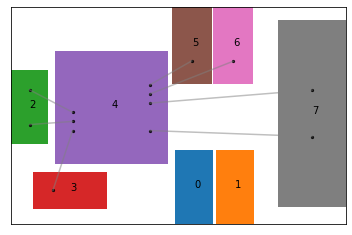

In [281]:
# First, just plot the manual layout (set all components to not be movable / rotateable / no constraints)
boxes = []
horiz_order = []
vert_order = []
for i in range(len(compw)):
    boxes.append(Box(compw[i], comph[i], compx[i], compy[i], 
                     initialr =[not r for r in initrot][i], initialmx=0, initialmy=0, idx=i, 
                     r=False, pl=False, m=False))
    
fp = FloorPlan(boxes, nets,adj,obj=False,norelpairs=None, ox=minx,oy=miny,boundary_W=maxx-minx, boundary_H=maxy-miny, 
               margin=0.5,horizontal_orderings=horiz_order, vertical_orderings=vert_order, 
               max_seconds=3800, num_cores=numCores-1, name=design)
p, c = fp.layout()
print(fp.h.value)
fp.show()

In [282]:
"""net separator vars """
jax.config.update('jax_platform_name', 'cpu')

A = adj
N = A.shape[0]
v = np.ones(N)
D = np.diag(v)
b = jnp.zeros(N)
d = jnp.zeros(N)

c1 = maxx-minx
c2 = maxy-miny
c3 = 0
C = jnp.block([[c1, c3],[c3, c2]])
assert c1*c2 >= c3
assert np.linalg.det(C) > 1e-5

In [283]:
"""net separator fns """
X_k = np.random.normal(size=(A.shape[0],2))
alpha=1e-2

def pairwise_dist(X):
    euc = lambda x: vmap(lambda y: jnp.linalg.norm(jnp.maximum(jnp.abs(x-y), eps))**2)(X)
    return vmap(euc)(X)

def _ec(X, U_i, r_i, A_i, B_i):
    return jnp.linalg.norm(jnp.clip(-A_i.T@X@U_i + (r_i + 1)*jnp.ones(U_i.shape[-1]), eps))**2 + \
           jnp.linalg.norm(jnp.clip(B_i.T@X@U_i - (r_i - 1)*jnp.ones(U_i.shape[-1]), eps))**2
    
def ec_objective(params, A, B):
    X, U, r = params
    return jnp.sum(vmap(partial(_ec,X))(U, r, A, B))

@jit
def ec_step(i, opt_state, edgetensor, fixed_idx=None):
    params = get_params(opt_state)
    g = grad(ec_objective)(params, edgetensor, edgetensor)
    #g_0 = jax.ops.index_update(g[0], fixed_idx, 0)
    g_0 = g[0].at[jnp.array(fixed_idx)].set(0)
    g = (g_0,g[1],g[2])
    return opt_update(i, g, opt_state)

def stress(params, W, D):
    X,_,_ = params
    return jnp.trace(X.T@(D-W)@X) + l*jnp.linalg.norm(X)**2

@jit
def step(i, opt_state, W, D, idx, fixed_idx=None):
    p,U,r = get_params(opt_state)
    g = grad(stress)((p[idx],U,r), W[jnp.ix_(idx,idx)], D[jnp.ix_(idx,idx)])
    #g_0 = jax.ops.index_add(jnp.zeros_like(p), idx, g[0], 
    #                      indices_are_sorted=False, unique_indices=True)
    g_0 = jnp.zeros_like(p).at[jnp.array(idx)].add(g[0])
    #g_0 = jax.ops.index_update(g_0, fixed_idx, 0)
    g_0 = g_0.at[jnp.array(fixed_idx)].set(0)
    g = (g_0, g[1], g[2])
    return opt_update(i, g, opt_state)

def rescale(X_transformed, minx, maxx, miny, maxy):
    X_transformed_x_rescaled = minx + ((X_transformed[:,0] - X_transformed[:,0].min())*(maxx - minx))/(X_transformed[:,0].max() - X_transformed[:,0].min())
    X_transformed_y_rescaled = miny + ((X_transformed[:,1] - X_transformed[:,1].min())*(maxy - miny))/(X_transformed[:,1].max() - X_transformed[:,1].min())
    #X_transformed_x_rescaled = np.minimum(np.maximum(minx, X_transformed[:,0]+minx+(maxx-minx)/2), maxx)
    #X_transformed_y_rescaled = np.minimum(np.maximum(miny, X_transformed[:,1]+miny+(maxy-miny)/2),maxy)
    X_transformed_rescaled = np.stack([X_transformed_x_rescaled,X_transformed_y_rescaled],axis=-1)
    return X_transformed_rescaled

In [284]:
d = csgraph.shortest_path(adj, directed=False, unweighted=False)
d = np.nan_to_num(d,nan=0.0, posinf=np.where(np.isinf(d),-np.Inf,d).max()+1)
# weights
eps = 1e-8
w = jnp.square(jnp.reciprocal(d + np.eye(*d.shape)))
w = w - jnp.diag(jnp.diag(w))
l = 0
dd = np.ones_like(w)
for i in range(w.shape[0]):
    for j in range(w.shape[1]):
        dd[i,j]*=10*(max(comph[i],compw[i]) + max(comph[j],compw[j]))

d = d * dd

nx = np.array([b.x.value for b in fp.boxes])
ny = np.array([b.y.value for b in fp.boxes])

w = (adj > 1)
positions = np.vstack([nx,ny]).T
numedges = jnp.where(w == 1)[0].shape[0]
edgetensor = np.zeros((numedges,)+positions.shape)
edgelist = jnp.where(w == 1)
for i in range(numedges):
    e1 = edgelist[0][i].item()
    e2 = edgelist[1][i].item()
    edgetensor[i,e1,0] = 1
    edgetensor[i,e2,1] = 1
edgetensor = jnp.array(edgetensor)
w = adj
d = np.diag(w.sum(0) + 0.1)

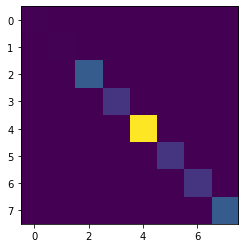

In [285]:
seed = 0
# initialise an array of 2D positions
rng = random.PRNGKey(seed)

K=w
pi = jnp.zeros(K.shape)
x = jnp.zeros(K.shape)
U = jnp.ones((numedges,2))
r = jnp.ones(numedges)
# show the shortest paths in a heat map.
# If any squares are white, then infinite paths exist and the algorithm will fail.
plt.imshow(d)
n = d.shape[0]
fixed_idx = [i for i,m in enumerate(movable) if m==False]

#embedding = SpectralEmbedding(n_components=2, affinity='precomputed')
#X_transformed = embedding.fit_transform(w)

X_transformed = np.asarray(random.normal(rng, (n,2)))
X_transformed_rescaled = X_transformed

X_transformed_rescaled = rescale(X_transformed, minx, maxx, miny, maxy)
init_positions = np.array([ip if movable[i]==True else [compx[i],compy[i]] 
                           for i,ip in enumerate(X_transformed_rescaled) ])
m = np.array([(maxx + minx) / 2,(maxy + miny) / 2])
init_positions = init_positions - m
params = (init_positions, U, r)
opt_init, opt_update, get_params = optimizers.adam(5e-2, b1=0.9, b2=0.999, eps=1e-08)
opt_state = opt_init(params)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, '44.663258')

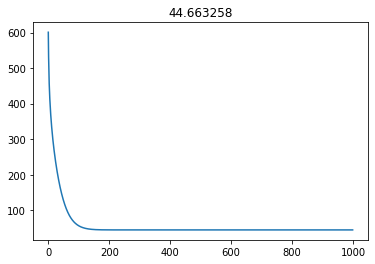

In [286]:
eta=1e-2
l=1e-1
itercount = itertools.count()

stress_hist = []
ec_hist = []
cvx_clst_hist = []
param_hist = []

for i in tqdm(range(1000)):
    idx = np.arange(n)
    for _ in range(10):
        opt_state = ec_step(i, opt_state, edgetensor, fixed_idx=fixed_idx)
    for _ in range(1):
        opt_state = step(i, opt_state, w, d, idx, fixed_idx=fixed_idx)
    
    params = get_params(opt_state)
    param_hist.append(params)
    stress_hist.append(stress(params, w, d))
    ec_hist.append(ec_objective(params, edgetensor, edgetensor))
        
end = datetime.datetime.now()
plt.plot(stress_hist)
plt.title(stress(params, w, d))

In [287]:
tp = params[0] + m
xt = rescale(tp, minx, maxx, miny, maxy)
compx = xt[:,0]
compy = xt[:,1]

In [288]:
compx

array([139.5336 , 139.5336 , 151.1528 , 150.216  , 152.2475 , 150.21611,
       150.21667, 157.933  ], dtype=float32)

num horizontal & vertical constraints: 15 0
Compiled constraints
                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Oct 25 11:42:49 AM: Your problem has 261 variables, 663 constraints, and 0 parameters.
(CVXPY) Oct 25 11:42:49 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 25 11:42:49 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 25 11:42:49 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 25 11:42:49 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVX

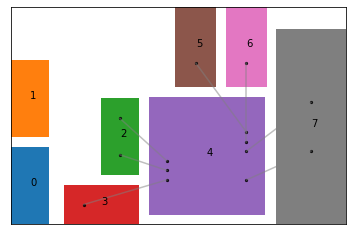

In [292]:
# Impose relative position constraints

# order constraints
vo = []
ho = []

norelpairs = []

for i1, x1 in enumerate(zip(compx, compy)):
    for i2, x2 in enumerate(zip(compx, compy)):
        #continue
        if i2 <= i1:
            continue
        # one of the two is a fixed node
        #if (((not movable[i1]) or (not movable[i2])) or (max(abs(x1[0] - x2[0]), abs(x1[1] - x2[1])) > 2.*max(maxx-minx, maxy-miny))):
        if ((max(abs(x1[0] - x2[0]), abs(x1[1] - x2[1])) > 0.4*max(maxx-minx, maxy-miny))):
            if abs(x1[0] - x2[0]) < abs(x1[1] - x2[1]):
                if x1[1] < x2[1]:
                    vo.append([i1, i2])
                else:
                    vo.append([i2,i1])
            else:
                if x1[0] < x2[0]:
                    ho.append([i1, i2])
                else:
                    ho.append([i2,i1]) 
        else:
            norelpairs.append([i1,i2])

horiz_order = [[boxes[i] for i in h] for h in ho]
vert_order = [[boxes[i] for i in v] for v in vo]
print('num horizontal & vertical constraints:',len(horiz_order),len(vert_order))

boxes = []
for i in range(len(compw)):
    boxes.append(Box(compw[i], comph[i], compx[i], compy[i], 
                     initialr =[not r for r in initrot][i], initialmx=0, initialmy=0, idx=i, 
                     r=False, pl=movable[i], m=False))
    
fp = FloorPlan(boxes, nets,adj,obj=True,norelpairs=None, ox=minx,oy=miny,boundary_W=maxx-minx, boundary_H=maxy-miny, 
               margin=0.5,horizontal_orderings=horiz_order, vertical_orderings=vert_order, 
               max_seconds=3800, num_cores=numCores-1, name=design)
p, c = fp.layout()
print(fp.h.value)
fp.show()

In [265]:
"""print db to file """
db.printKiCad()

printKiCad() outputFileName: output.bm9.routed.kicad_pcb


In [ ]:
"""write back to db """
for i in range(db.getInstancesCount()):
    inst = db.getInstance(i)
    compid = inst.getComponentId()
    
    box = fp.boxes[i]
    
    xpos = box.x.value.item() + 0.5 * ((1-fp.boxes[i].r.value)*fp.boxes[i].w.value + 
                                          (fp.boxes[i].r.value)*fp.boxes[i].h.value)
    ypos = box.y.value.item()+ 0.5 * ((1-fp.boxes[i].r.value)*fp.boxes[i].h.value + 
                                         (fp.boxes[i].r.value)*fp.boxes[i].w.value)
    inst.setX(xpos)
    inst.setY(ypos)

    rotated = box.r.value
    mirroredX = box.mx.value.item()
    mirroredY = box.my.value.item()
    
    init_angle = inst.getAngle()
 
    print(i, xpos, ypos, box.w, box.h,init_angle, rotated)

    if (init_angle==0) and (rotated == 0.0):
        inst.setAngle(90)
    elif (init_angle==0) and (rotated == 1.0):
        inst.setAngle(0)
    elif (init_angle==90) and (rotated == 0.0):
        inst.setAngle(90)
    elif (init_angle==90) and (rotated == 1.0):
        inst.setAngle(180)
    elif (init_angle==180) and (rotated == 0.0):
        inst.setAngle(270)
    elif (init_angle==180) and (rotated == 1.0):
        inst.setAngle(180)
    elif (init_angle==270) and (rotated == 0.0):
        inst.setAngle(270)
    elif (init_angle==270) and (rotated == 1.0):
        inst.setAngle(0)
    print(i, xpos, ypos, box.w, box.h,inst.getAngle(), rotated)    
    

In [38]:
[b.x.value for b in boxes]

[153.313,
 155.873,
 139.82564758300782,
 141.84564758300783,
 142.38564758300782,
 146.38564758300782,
 153.2856475830078,
 array(149.08564758)]

In [39]:
movable

[True, True, True, True, True, True, True, False]

In [ ]:
#7 156.083 104.902 True 10.2 3.7 90 False